In [50]:
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [52]:
tweets = pd.read_csv('train.csv')
tweets_test = pd.read_csv('test.csv')

tweets['len_text']=tweets['text'].str.len()
tweets_test['len_text']=tweets_test['text'].str.len()

tweets['keyword'] = tweets['keyword'].str.replace('%20', ' ')
tweets['keyword'].fillna('no keyword', inplace = True)

tweets_test['keyword'] = tweets_test['keyword'].str.replace('%20', ' ')
tweets_test['keyword'].fillna('no keyword', inplace = True)

tweets = tweets.sample(frac=1,random_state=1)

In [53]:
tweets['clean_text'] = tweets['text'].str.lower()
tweets_test['clean_text'] = tweets_test['text'].str.lower()

In [54]:
def only_letters(tweet):
    tweet = re.sub(r'http\S*', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return tweet

In [55]:
tweets['clean_text'] = tweets['clean_text'].apply(only_letters)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(only_letters)

In [56]:
#Tokenización
from nltk.tokenize import word_tokenize
tweets['clean_text'] = tweets['clean_text'].apply(word_tokenize)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(word_tokenize)
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [57]:
def filter_stopwords(tokenized_text):
    not_stopwords=[]
    for w in tokenized_text:
        if w not in stop_words:
            not_stopwords.append(w)
    return not_stopwords

In [58]:
tweets['clean_text'] = tweets['clean_text'].apply(filter_stopwords)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(filter_stopwords)

In [59]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [60]:
def lemmatize_tweet(tweet):
    lemmatized_words = []
    for word in tweet:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

In [61]:
tweets['clean_text'] = tweets['clean_text'].apply(lemmatize_tweet)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lemmatize_tweet)
tweets['clean_text'] = tweets['clean_text'].apply(lambda text:' '.join(text))
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text:' '.join(text))
tweets['clean_text'] = tweets['clean_text'].apply(lambda text: re.sub(r'amp | im', '', text))
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text: re.sub(r'amp | im', '', text))

In [62]:
#Nuevos features

In [63]:
#Hashtags del tweet

In [64]:
def get_hashtags(s):
    return list(part[1:] for part in s.split() if part.startswith('#'))

In [65]:
tweets['hashtags'] = tweets['text'].apply(get_hashtags)
tweets_test['hashtags'] = tweets_test['text'].apply(get_hashtags)

In [66]:
#Proporción de la longitud del hashtag con respecto a la del texto

In [67]:
def hashtag_length_proportion(hashtags,length):
    return len(''.join(hashtags))/length

In [68]:
tweets['len_hashtag_over_text'] = tweets.apply(lambda data: hashtag_length_proportion(data['hashtags'],data['len_text']),axis=1)
tweets_test['len_hashtag_over_text'] = tweets_test.apply(lambda data: hashtag_length_proportion(data['hashtags'],data['len_text']),axis=1)

In [69]:
#Cantidad de hashtags del tweet

In [70]:
def hashtags_count(l):
    return len(l)

In [71]:
tweets['hashtags_count']=tweets['hashtags'].apply(hashtags_count)
tweets_test['hashtags_count']=tweets_test['hashtags'].apply(hashtags_count)

In [72]:
#Usuarios mencionados en el tweet

In [73]:
def get_mentioned_users(s):
    return list(part[1:] for part in s.split() if part.startswith('@'))

In [74]:
tweets['users'] = tweets['text'].apply(get_mentioned_users)
tweets_test['users'] = tweets_test['text'].apply(get_mentioned_users)

In [75]:
def users_count(l):
    return len(l)

In [76]:
tweets['users_count']=tweets['users'].apply(users_count)
tweets_test['users_count']=tweets_test['users'].apply(users_count)

In [77]:
#urls en el texto

In [78]:
def find_url(text):
    urls = re.findall(r'(https?://\S+)', text)
    return urls

In [79]:
tweets['urls']=tweets['text'].apply(find_url)
tweets_test['urls']=tweets_test['text'].apply(find_url)

In [80]:
def urls_count(l):
    return len(l)

In [81]:
tweets['urls_count'] = tweets['urls'].apply(lambda x: len(x))
tweets_test['urls_count'] = tweets_test['urls'].apply(lambda x: len(x))

In [82]:
def has_url(text):
    return int('http' in text)

In [83]:
tweets['has_url']=tweets['text'].apply(has_url)
tweets_test['has_url']=tweets_test['text'].apply(has_url)

In [84]:
#Mean encoding keyword
tweets['keyword_encoded'] = tweets.groupby('keyword')['target'].transform('mean')

In [85]:
keywords_dict = pd.Series(tweets['keyword_encoded'].values, index=tweets['keyword']).to_dict()

In [86]:
tweets_test['keyword_encoded']= tweets_test['keyword'].map(keywords_dict)

In [87]:
tweets['len_clean_text'] = tweets['clean_text'].str.len()
tweets_test['len_clean_text'] = tweets_test['clean_text'].str.len()

#Proporción de longitud de clean_text con respecto texto original
tweets['len_clean_text_over_text'] = tweets['len_clean_text']/tweets['len_text']
tweets_test['len_clean_text_over_text'] = tweets_test['len_clean_text']/tweets_test['len_text']

In [88]:
tweets.head()

,id,keyword,location,text,target,len_text,clean_text,hashtags,len_hashtag_over_text,hashtags_count,users,users_count,urls,urls_count,has_url,keyword_encoded,len_clean_text,len_clean_text_over_text
3228,4632,emergency services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1,141,goulburn man henry van bilsen missing emergenc...,[],0.0,0,[],0,[http://t.co/z99pKJzTRp],1,1,0.333333,90,0.638298
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0,138,thing fear organizationsfluctuations disturban...,[],0.0,0,[],0,[],0,0,0.125000,103,0.746377
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0,23,tsunamiesh hey esh,[],0.0,0,[tsunami_esh],1,[],0,0,0.323529,18,0.782609
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0,140,potus drown water entering lung alive caused g...,[],0.0,0,[POTUS],1,[],0,0,0.093750,80,0.571429
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\r\nThese wounds they will ...,1,51,crawling skin wound hea,[],0.0,0,[],0,[],0,0,0.303030,23,0.450980


In [89]:
#Me quedo con las columnas numéricas
df = tweets.loc[:,['len_text','len_hashtag_over_text','hashtags_count','has_url','urls_count','users_count','keyword_encoded','len_clean_text','len_clean_text_over_text']]
df.head()

,len_text,len_hashtag_over_text,hashtags_count,has_url,urls_count,users_count,keyword_encoded,len_clean_text,len_clean_text_over_text
3228,141,0.0,0,1,1,0,0.333333,90,0.638298
3706,138,0.0,0,0,0,0,0.125000,103,0.746377
6957,23,0.0,0,0,0,1,0.323529,18,0.782609
2887,140,0.0,0,0,0,1,0.093750,80,0.571429
7464,51,0.0,0,0,0,0,0.303030,23,0.450980


In [90]:
tweets_dmatrix = xgb.DMatrix(data=df,label=tweets['target'])

In [92]:
df_test = tweets_test.loc[:,['len_text','len_hashtag_over_text','hashtags_count','has_url','urls_count','users_count','keyword_encoded','len_clean_text','len_clean_text_over_text']]
df_test.head()

,len_text,len_hashtag_over_text,hashtags_count,has_url,urls_count,users_count,keyword_encoded,len_clean_text,len_clean_text_over_text
0,34,0.00000,0,0,0,0,0.688525,27,0.794118
1,64,0.15625,1,0,0,0,0.688525,50,0.781250
2,96,0.00000,0,0,0,0,0.688525,54,0.562500
3,40,0.40000,2,0,0,0,0.688525,36,0.900000
4,45,0.00000,0,0,0,0,0.688525,34,0.755556


In [93]:
y = tweets['target']

In [94]:
params={
 "learning_rate"    : [0.10, 0.15, 0.20, 0.25] ,
 "max_depth"        : [ 3, 4, 5, 6],
 "min_child_weight" : [ 1, 3, 5],
 "gamma"            : [ 0.1, 0.2 , 0.3],
 "colsample_bytree" : [ 0.4, 0.5 , 0.7],
 "n_estimators"     : [ 70, 80, 90, 100]
}

In [95]:
model = xgb.XGBClassifier()

In [96]:
random_search = RandomizedSearchCV(model,param_distributions=params,scoring='f1',cv=5,verbose=0,n_iter=1700)

In [97]:
random_search.fit(df,y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_i

In [98]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=None, n_estimators=80, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [99]:
random_search.best_params_

{'n_estimators': 80,
 'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [100]:
model = random_search.best_estimator_

In [101]:
#Predicciones set de train
preds = model.predict(data=df)

In [102]:
f1score = f1_score(tweets['target'], preds)
print(f'Counts model score: {f1score}')

Counts model score: 0.7468906477144241


In [103]:
rmse = np.sqrt(mean_squared_error(tweets['target'], preds))
print(f'RMSE: %f' % (rmse))

RMSE: 0.453687


In [104]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(tweets['target'], preds))

[[3734  608]
 [ 959 2312]]


In [105]:
#Predicciones set de test
preds_test = model.predict(data=df_test)
preds_test

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [106]:
tweets_test['target'] = preds_test.astype(int)
submission = tweets_test.loc[:,['id','target']]

In [107]:
submission.to_csv(path_or_buf='submissionxgb.csv',header=True,index=False)

Feature importance

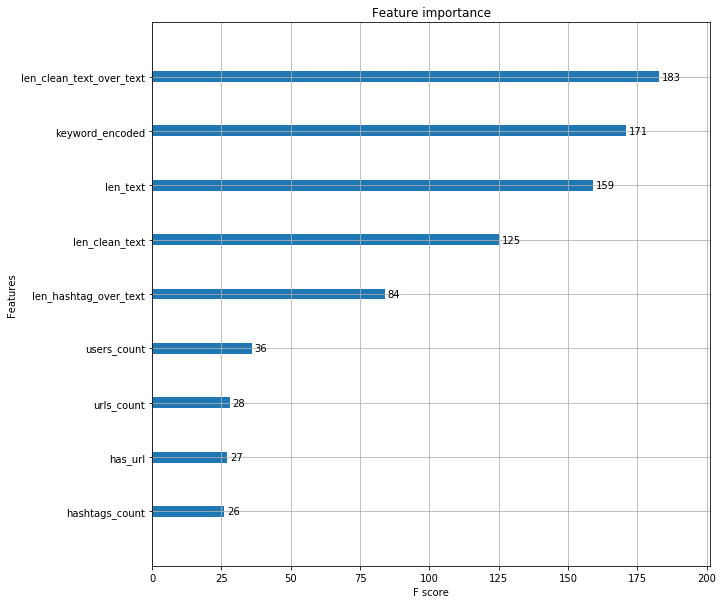

In [108]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, max_num_features=10, ax=ax)

In [109]:
import pickle
pickle.dump(model, open("modeloxgb", "wb"))